# 1. Set Up

In [1]:
#install mtcnn
!pip install mtcnn

#mount Goolge Drive
from google.colab import drive
drive.mount('/content/gdrive')

#set file path
path = "/content/gdrive/My Drive/iss/project/"

     |████████████████████████████████| 2.3MB 2.9MB/s 
Mounted at /content/gdrive


In [2]:
#import library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import layers
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import mtcnn
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from scipy.spatial.distance import cosine
from PIL import Image
from tensorflow.keras import backend as K
from matplotlib import cm
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

face_cascade=cv2.CascadeClassifier("/content/gdrive/My Drive/iss/project/haarcascade_frontalface_default.xml")
haarcascade_lefteye_2splits=cv2.CascadeClassifier("/content/gdrive/My Drive/iss/project/haarcascade_lefteye_2splits.xml")
haarcascade_righteye_2splits=cv2.CascadeClassifier("/content/gdrive/My Drive/iss/project/haarcascade_righteye_2splits.xml")
haarcascade_eye_tree_eyeglasses=cv2.CascadeClassifier("/content/gdrive/My Drive/iss/project/haarcascade_eye_tree_eyeglasses.xml")

if K.backend()=='tensorflow':
    keras.backend.set_image_data_format("channels_last")

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 2. Data Processing

In [3]:
def samegroup(eye1,eye2):
  dx = min(eye1[0]+eye1[2], eye2[0]+eye1[2]) - max(eye1[0], eye2[0])
  dy = min(eye1[1]+eye1[3], eye2[1]+eye1[3]) - max(eye1[1], eye2[1])
  if (dx>=0) and (dy>=0) and (dx*dy>0.5):
      return True
  return False

def get_eyes(roi_gray):
  # Creating variable eyes
  haarcascade_lefteye_2splits1 = haarcascade_lefteye_2splits.detectMultiScale(roi_gray, 1.1, 3)
  haarcascade_righteye_2splits1 = haarcascade_righteye_2splits.detectMultiScale(roi_gray, 1.1, 3)
  eyeglasses1 = haarcascade_eye_tree_eyeglasses.detectMultiScale(roi_gray, 1.1, 3)

  eye_group = []
  group = 0
  for (ex , ey,  ew,  eh) in haarcascade_lefteye_2splits1:
    eye_group.append([ex , ey,  ew,  eh, group])
    group += 1
    #cv2.rectangle(lefteyexml,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
  for (ex , ey,  ew,  eh) in haarcascade_righteye_2splits1:
    grouped = False
    for g in eye_group:
      if samegroup([ex , ey,  ew,  eh],g):
        eye_group.append([ex , ey,  ew,  eh, g[4]])
        grouped = True
        break
    if grouped == False:
      eye_group.append([ex , ey,  ew,  eh, group])
      group +=1
  for (ex , ey,  ew,  eh) in eyeglasses1:
    grouped = False
    for g in eye_group:
      if samegroup([ex , ey,  ew,  eh],g):
        eye_group.append([ex , ey,  ew,  eh, g[4]])
        grouped = True
        break
    if grouped == False:
      eye_group.append([ex , ey,  ew,  eh, group])
      group +=1
    #cv2.rectangle(eyeglassesxml,(ex,ey),(ex+ew,ey+eh),(255,255,255),2)
  #print("total groups : "+str(group))
  eyes = []
  for i in range(group):
    ecount = 0
    ex = 0
    ey = 0
    ew = 0
    eh = 0
    for e in eye_group:
      if e[4] == i:
        ex += e[0]
        ey += e[1]
        ew += e[2]
        eh += e[3]
        ecount+=1
    if ecount > 1:
      ex = int(ex/ecount)
      ey = int(ey/ecount)
      ew = int(ew/ecount)
      eh = int(eh/ecount)
    #print("Group : "+str(i))
    #print("position : {},{},{},{}",ex,ey,ew,eh)
    if len(eyes) <2 :
      if len(eyes) == 1:
        tmp = eyes[0]
        if eyes[0][2]*eyes[0][3] < ew*eh:
          eyes[0] = [ex,ey,ew,eh]
          eyes.append(tmp)
        else:
          eyes.append([ex,ey,ew,eh])
      else:
        eyes.append([ex,ey,ew,eh])
      #print(len(eyes))
    else:
      if eyes[0][2]*eyes[0][3] < ew*eh:
        tmp = eyes[0]
        eyes[0] = [ex,ey,ew,eh]
        eyes[1] = tmp
      elif eyes[1][2]*eyes[1][3] < ew*eh:
        eyes[1] = [ex,ey,ew,eh]
  return eyes



def rotate_img(img_path):
    img = cv2.imread(img_path)
    img_original = img    

    lefteyexml = img
    righteyexml = img
    eyexml = img
    eyeglassesxml = img

    lefteyexml2 = img
    righteyexml2 = img
    eyexml2 = img
    eyeglassesxml2 = img

    lefteyexml3 = img
    righteyexml3 = img
    eyexml3 = img
    eyeglassesxml3 = img

    # Converting the image into grayscale
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f_count = 0
    #try:
    # Creating variable faces
    faces= face_cascade.detectMultiScale (gray, 1.1, 4)
    # Defining and drawing the rectangle around the face
    for(x,y,w,h) in faces:
      f_count+=1
    # Creating two regions of interest
    roi_gray=gray
    roi_color=img
    
    eyes = get_eyes(roi_gray)    

    #for e in eyes:
    #  cv2.rectangle(eyeglassesxml,(e[0],e[1]),(e[0]+e[2],e[1]+e[3]),(0,0,255),2)

    if len(eyes) ==2:
      # Creating for loop in order to divide one eye from another
      eye_1 = eyes[0]
      eye_2 = eyes[1]
      
      if eye_1[0] < eye_2[0]:
          left_eye = eye_1
          right_eye = eye_2
      else:
          left_eye = eye_2
          right_eye = eye_1
      # Calculating coordinates of a central points of the rectangles
      left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
      left_eye_x = left_eye_center[0] 
      left_eye_y = left_eye_center[1]
        
      right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
      right_eye_x = right_eye_center[0]
      right_eye_y = right_eye_center[1]

      if left_eye_y > right_eye_y:
          A = (right_eye_x, left_eye_y)
          # Integer -1 indicates that the image will rotate in the clockwise direction
          direction = -1 
      else:
          A = (left_eye_x, right_eye_y)
        # Integer 1 indicates that image will rotate in the counter clockwise  
        # direction
          direction = 1 

      delta_x = right_eye_x - left_eye_x
      delta_y = right_eye_y - left_eye_y
      angle=np.arctan(delta_y/delta_x)
      angle = (angle * 180) / np.pi

      # Width and height of the image
      h, w = img.shape[:2]
      # Calculating a center point of the image
      # Integer division "//"" ensures that we receive whole numbers
      center = (w // 2, h // 2)
      # Defining a matrix M and calling
      # cv2.getRotationMatrix2D method
      M = cv2.getRotationMatrix2D(center, (angle), 1.0)
      # Applying the rotation to our image using the
      # cv2.warpAffine method
      rotated = cv2.warpAffine(img_original, M, (w, h))

      rotated = cv2.resize(rotated,(160,160),interpolation=cv2.INTER_CUBIC)
      rotated = cv2.cvtColor(rotated,cv2.COLOR_BGR2GRAY)
      rotated = cv2.cvtColor(rotated,cv2.COLOR_GRAY2RGB)
      return rotated

    return img_original

In [4]:
# create the detector, using default weights
detector = MTCNN()
def extract_face(filename, required_size=(160, 160)):
    npimg = rotate_img(filename)
    '''
    image = Image.fromarray(np.uint8(cm.gist_earth(npimg)*255))
    #image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array
    '''
    return npimg



# 3. Load Model

In [5]:
#Define Triplet_loss
def triplet_loss(y_true, y_pred, alpha = 0.2):
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
  
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

#load pre-trained FaceNet Model
facenet_model = load_model(path+'facenet_keras.h5', custom_objects={ 'loss': triplet_loss })

# 4. Get image encoding

In [6]:
from sklearn.preprocessing import Normalizer
in_encoder = Normalizer('l2')

def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face - mean) / std
    #print(face.shape)
    face = cv2.resize(face,(160,160))
    face = np.expand_dims(face, axis=0)
    #print(face.shape)
    encode = model.predict(face)[0]
    #print(encode)
    return encode

def who_is_it(image_path, database, model):
    
    #Compute the target "encoding" for the image
    face = extract_face(image_path)
    encoding = get_embedding(facenet_model,face)
    encoding = in_encoder.transform(np.expand_dims(encoding, axis=0))[0]
    
    # Initialize "min_dist" to a large value
    min_dist = float("inf")
    identity = 'Not in the database'
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc
        dist = cosine(db_enc,encoding)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name
        if dist < 0.5 and dist < min_dist:
            min_dist = dist
            identity = name

    
    #if min_dist > 0.5:
    #    print("Not in the database.")
    #else:
    #    print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

def predict(img, database, model):
    
    #Compute the target "encoding" for the image
    #face = extract_face(image_path)
    encoding = get_embedding(facenet_model,img)
    encoding = in_encoder.transform(np.expand_dims(encoding, axis=0))[0]
    
    # Initialize "min_dist" to a large value
    min_dist = float("inf")
    identity = 'Not in the database'
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc
        dist = cosine(db_enc,encoding)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name
        if dist < 0.8 and dist < min_dist:
            min_dist = dist
            identity = name

    
    #if min_dist > 0.5:
    #    print("Not in the database.")
    #else:
    #    print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

# 5. Build image encoding library

In [7]:
database = {}
face = extract_face("/content/gdrive/My Drive/iss/project/data/austin/6.jpg")
database["austin"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/norman/IMG_5368.JPG")
database["norman"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/zhengmin/IMG_0963.jpg")
database["zhengmin"] = get_embedding(facenet_model,face)

face = extract_face("/content/gdrive/My Drive/iss/project/data/aidai/1_0_aidai_0019.jpg")
database["aidai"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/anhu/1_0_anhu_0026.jpg")
database["anhu"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/axin/1_0_axin_0084.jpg")
database["axin"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/baibaihe/1_0_baibaihe_0193.jpg")
database["baibaihe"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/baijingting/1_0_baijingting_0060.jpg")
database["baijingting"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/baike/1_0_baike_0048.jpg")
database["baike"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/baobeier/1_0_baobeier_0050.jpg")
database["baobeier"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/baojianfeng/1_0_baojianfeng_0209.jpg")
database["baojianfeng"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/benxi/1_0_benxi_0133.jpg")
database["benxi"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/caiguoqing/1_0_caiguoqing_0158.jpg")
database["caiguoqing"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/caihancen/1_0_caihancen_0100.jpg")
database["caihancen"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/caiyilin/1_0_caiyilin_0047.jpg")
database["caiyilin"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/caizhuoyan/1_0_caizhuoyan_0022.jpg")
database["caizhuoyan"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/caobingkun/1_0_caobingkun_0130.jpg")
database["caobingkun"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/caoying/1_0_caoying_0047.jpg")
database["caoying"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/caoyunjin/1_0_caoyunjin_0243.jpg")
database["caoyunjin"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/cengyongti/1_0_cengyongti_0250.jpg")
database["cengyongti"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/changshilei/1_0_changshilei_0223.jpg")
database["changshilei"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/changyuan/1_0_changyuan_0110.jpg")
database["changyuan"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenbailin/1_0_chenbailin_0075.jpg")
database["chenbailin"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenderong/1_0_chenderong_0157.jpg")
database["chenderong"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chendouling/1_0_chendouling_0034.jpg")
database["chendouling"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenfarong/1_0_chenfarong_0147.jpg")
database["chenfarong"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenglong/1_0_chenglong_0039.jpg")
database["chenglong"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenguanxi/1_0_chenguanxi_0012.jpg")
database["chenguanxi"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenhaomin/1_0_chenhaomin_0097.jpg")
database["chenhaomin"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenhe/1_0_chenhe_0104.jpg")
database["chenhe"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenhuilin/1_0_chenhuilin_0081.jpg")
database["chenhuilin"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenhuixian/1_0_chenhuixian_0073.jpg")
database["chenhuixian"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenjiaqi/0_0_chenjiaqi_0002.jpg")
database["chenjiaqi"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenkun/1_0_chenkun_0118.jpg")
database["chenkun"] = get_embedding(facenet_model,face)

face = extract_face("/content/gdrive/My Drive/iss/project/data/chenlong/1_0_chenlong_0001.jpg")
database["chenlong"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenqiaoen/1_0_chenqiaoen_0096.jpg")
database["chenqiaoen"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenshu/1_0_chenshu_0139.jpg")
database["chenshu"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenweiting/1_0_chenweiting_0088.jpg")
database["chenweiting"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenxiang/0_0_chenxiang_0107.jpg")
database["chenxiang"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenxinyu/1_0_chenxinyu_0113.jpg")
database["chenxinyu"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenxuedong/1_0_chenxuedong_0171.jpg")
database["chenxuedong"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenyao/1_0_chenyao_0215.jpg")
database["chenyao"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenyi/0_0_chenyi_0053.jpg")
database["chenyi"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenyixun/1_0_chenyixun_0166.jpg")
database["chenyixun"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenyufan/0_0_chenyufan_0054.jpg")
database["chenyufan"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/chenzhipeng/0_0_chenzhipeng_0014.jpg")
database["chenzhipeng"] = get_embedding(facenet_model,face)

face = extract_face("/content/gdrive/My Drive/iss/project/data/daipeini/1_0_daipeini_0080.jpg")
database["daipeini"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/dazhangwei/1_0_dazhangwei_0001.jpg")
database["dazhangwei"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/dengchao/1_0_dengchao_0018.jpg")
database["dengchao"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/denglun/0_0_denglun_0149.jpg")
database["denglun"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/dengziqi/1_0_dengziqi_0057.jpg")
database["dengziqi"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/dilireba/1_0_dilireba_0162.jpg")
database["dilireba"] = get_embedding(facenet_model,face)
#face = extract_face("/content/gdrive/My Drive/iss/project/data/dingding/1_0_dingding_0011.jpg")
#database["dingding"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/ditianlin/1_0_ditianlin_0215.jpg")
database["ditianlin"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/dongchengpeng/1_0_dongchengpeng_0069.jpg")
database["dongchengpeng"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/dongjie/1_0_dongjie_0050.jpg")
database["dongjie"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/dongxuan/1_0_dongxuan_0203.jpg")
database["dongxuan"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/duhaitao/1_0_duhaitao_0189.jpg")
database["duhaitao"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/dujiang/1_0_dujiang_0173.jpg")
database["dujiang"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/duwenze/1_0_duwenze_0052.jpg")
database["duwenze"] = get_embedding(facenet_model,face)


face = extract_face("/content/gdrive/My Drive/iss/project/data/fanbingbing/1_0_fanbingbing_0021.jpg")
database["fanbingbing"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/fanganna/1_0_fanganna_0129.jpg")
database["fanganna"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/fangzuming/1_0_fangzuming_0111.jpg")
database["fangzuming"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/fanshiqi/1_0_fanshiqi_0158.jpg")
database["fanshiqi"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/fanwei/1_0_fanwei_0155.jpg")
database["fanwei"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/fanyichen/1_0_fanyichen_0001.jpg")
database["fanyichen"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/fengjianyu/1_0_fengjianyu_0067.jpg")
database["fengjianyu"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/fuxinbo/1_0_fuxinbo_0027.jpg")
database["fuxinbo"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/ganwei/1_0_ganwei_0083.jpg")
database["ganwei"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/gaohu/1_0_gaohu_0111.jpg")
database["gaohu"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/gaoyixiang/1_0_gaoyixiang_0196.jpg")
database["gaoyixiang"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/gaoyuanyuan/1_0_gaoyuanyuan_0194.jpg")
database["gaoyuanyuan"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/gongbeibi/1_0_gongbeibi_0001.jpg")
database["gongbeibi"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/guanxiaotong/1_0_guanxiaotong_0037.jpg")
database["guanxiaotong"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/guanyue/1_0_guanyue_0208.jpg")
database["guanyue"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/gulinazha/1_0_gulinazha_0208.jpg")
database["gulinazha"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/guobiting/1_0_guobiting_0100.jpg")
database["guobiting"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/guofucheng/1_0_guofucheng_0157.jpg")
database["guofucheng"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/guojingfei/1_0_guojingfei_0048.jpg")
database["guojingfei"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/guojingjing/1_0_guojingjing_0189.jpg")
database["guojingjing"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/guojingming/1_0_guojingming_0121.jpg")
database["guojingming"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/guojunchen/1_0_guojunchen_0004.jpg")
database["guojunchen"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/guoxiaofeng/1_0_guoxiaofeng_0245.jpg")
database["guoxiaofeng"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/gutianle/1_0_gutianle_0092.jpg")
database["gutianle"] = get_embedding(facenet_model,face)

face = extract_face("/content/gdrive/My Drive/iss/project/data/haiqing/1_0_haiqing_0109.jpg")
database["haiqing"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/hanbaoyi/0_0_hanbaoyi_0119.jpg")
database["hanbaoyi"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/handongjun/1_0_handongjun_0145.jpg")
database["handongjun"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/hangeng/1_0_hangeng_0170.jpg")
database["hangeng"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/hanqingzi/1_0_hanqingzi_0208.jpg")
database["hanqingzi"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/hanxue/1_0_hanxue_0042.jpg")
database["hanxue"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/haofeier/1_0_haofeier_0054.jpg")
database["haofeier"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/hedujuan/1_0_hedujuan_0007.jpg")
database["hedujuan"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/hejiong/0_0_hejiong_0111.jpg")
database["hejiong"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/hejunxiang/1_0_hejunxiang_0088.jpg")
database["hejunxiang"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/hewenhui/1_0_hewenhui_0118.jpg")
database["hewenhui"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/houminghao/1_0_houminghao_0116.jpg")
database["houminghao"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/houpeicen/1_0_houpeicen_0147.jpg")
database["houpeicen"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangbo/1_0_huangbo_0001.jpg")
database["huangbo"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huanghaibo/1_0_huanghaibo_0036.jpg")
database["huanghaibo"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangjinglun/1_0_huangjinglun_0164.jpg")
database["huangjinglun"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangjingyu/1_0_huangjingyu_0015.jpg")
database["huangjingyu"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huanglei/1_0_huanglei_0075.jpg")
database["huanglei"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangqiusheng/1_0_huangqiusheng_0002.jpg")
database["huangqiusheng"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangrihua/1_0_huangrihua_0081.jpg")
database["huangrihua"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangshengyi/1_0_huangshengyi_0245.jpg")
database["huangshengyi"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangtingting/1_0_huangtingting_0015.jpg")
database["huangtingting"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangxiaoming/1_0_huangxiaoming_0184.jpg")
database["huangxiaoming"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangxuan/1_0_huangxuan_0164.jpg")
database["huangxuan"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangzhiwei/1_0_huangzhiwei_0175.jpg")
database["huangzhiwei"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangzhongkun/1_0_huangzhongkun_0122.jpg")
database["huangzhongkun"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangzitao/1_0_huangzitao_0096.jpg")
database["huangzitao"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huangzongze/1_0_huangzongze_0090.jpg")
database["huangzongze"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huashao/1_0_huashao_0048.jpg")
database["huashao"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/hudie/1_0_hudie_0039.jpg")
database["hudie"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huge/1_0_huge_0012.jpg")
database["huge"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huhaiquan/1_0_huhaiquan_0001.jpg")
database["huhaiquan"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/hujing/1_0_hujing_0192.jpg")
database["hujing"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huke/1_0_huke_0191.jpg")
database["huke"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huojianhua/0_0_huojianhua_0125.jpg")
database["huojianhua"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huosiyan/1_0_huosiyan_0216.jpg")
database["huosiyan"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huozun/1_0_huozun_0195.jpg")
database["huozun"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huxia/1_0_huxia_0122.jpg")
database["huxia"] = get_embedding(facenet_model,face)
face = extract_face("/content/gdrive/My Drive/iss/project/data/huyanbin/1_0_huyanbin_0211.jpg")
database["huyanbin"] = get_embedding(facenet_model,face)

In [ ]:
#load data from folder
#test_dir = '/content/gdrive/My Drive/iss/project/data/aidai'
#test_imgs = ['/content/gdrive/My Drive/iss/project/data/aidai/{}'.format(i) for i in os.listdir(test_dir)]

In [ ]:
#load data from pre-processed file
with open('/content/gdrive/My Drive/iss/project/data/face_data_custom.npy', 'rb') as f:
    test_imgs = np.load(f)

with open('/content/gdrive/My Drive/iss/project/data/face_lable_custom.npy', 'rb') as f:
    test_imgs_lable = np.load(f)

In [ ]:
def test_image(img_list):
    img_count = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    erro_img = 0
    for idx, img in enumerate(img_list):
    #for img in img_list:
        try:
            img_count +=1
            min_dist, identity = predict(img,database,facenet_model)
            #if identity == 'aidai':
            if identity == 'Not in the database' :
              fn += 1
            else:
              if identity == test_imgs_lable[idx]:
                tp += 1
              else:
                fp += 1
        except:
            #print("img error")
            erro_img+=1
    #if img_count > 0:
        #return result/img_count
    return tp,tn,fp,fn
    #return 0.0

In [ ]:
tp,tn,fp,fn = test_image(test_imgs)
print("True Positive: " + str(tp))
print("True Negative: " + str(tn))
print("False Positive: " + str(fp))
print("False Negative: " + str(fn))

True Positive: 50
True Negative: 0
False Positive: 9
False Negative: 0


In [ ]:
print("Accuracy : "+ str((tp+tn)/(tp+fp+fn+tn)))
print("Precision : "+ str(tp/(tp+fp)))
print("Recall : " +str(tp/(tp+fn)))

Accuracy : 0.847457627118644
Precision : 0.847457627118644
Recall : 1.0


In [ ]:
tp,tn,fp,fn = test_image(test_imgs)
print("True Positive: " + str(tp))
print("True Negative: " + str(tn))
print("False Positive: " + str(fp))
print("False Negative: " + str(fn))

True Positive: 1260
True Negative: 16
False Positive: 508
False Negative: 25


In [ ]:
print("Accuracy : "+ str((tp+tn)/(tp+fp+fn+tn)))
print("Precision : "+ str(tp/(tp+fp)))
print("Recall : " +str(tp/(tp+fn)))

Accuracy : 0.7053620784964069
Precision : 0.7126696832579186
Recall : 0.980544747081712


In [ ]:
tp,tn,fp,fn = test_image(test_imgs)
print("True Positive: " + str(tp))
print("True Negative: " + str(tn))
print("False Positive: " + str(fp))
print("False Negative: " + str(fn))

True Positive: 5814
True Negative: 0
False Positive: 2140
False Negative: 201


In [ ]:
#test data
print("Accuracy : "+ str((tp+tn)/(tp+fp+fn+tn)))
print("Precision : "+ str(tp/(tp+fp)))
print("Recall : " +str(tp/(tp+fn)))

Accuracy : 0.7129368485591662
Precision : 0.7309529796328891
Recall : 0.9665835411471322


In [ ]:
#test all data classed with no preprocessing
result = test_image(test_imgs)
print("Accuracy: " + str(result))

Accuracy: 0.21622539516323036


In [ ]:
result = test_image(test_imgs)
print("Accuracy: " + str(result))

img error
img error
Accuracy: 0.8


In [ ]:
#test with 60 
result = test_image(test_imgs)
print("Accuracy: " + str(result))

img error
img error
img error
Accuracy: 0.7722222222222223


# 6. Output Model and Encoding DB

In [8]:
import csv

with open('/content/gdrive/My Drive/iss/project/data/dict.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in database.items():
       value = list(value)
       writer.writerow([key, value])
    #for key, value in database.items():
       #value = list(value)
       #value = np.fromstring(value.tostring())
       #re.sub("\s+", ",", value.strip())
       #value = "[" + value +"]"
       #print(value)
       #writer.writerow([key, value])

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

face_cascade=cv2.CascadeClassifier("/content/gdrive/My Drive/iss/project/haarcascade_frontalface_default.xml")
haarcascade_lefteye_2splits=cv2.CascadeClassifier("/content/gdrive/My Drive/iss/project/haarcascade_lefteye_2splits.xml")
haarcascade_righteye_2splits=cv2.CascadeClassifier("/content/gdrive/My Drive/iss/project/haarcascade_righteye_2splits.xml")
haarcascade_eye=cv2.CascadeClassifier("/content/gdrive/My Drive/iss/project/haarcascade_eye.xml")
haarcascade_eye_tree_eyeglasses=cv2.CascadeClassifier("/content/gdrive/My Drive/iss/project/haarcascade_eye_tree_eyeglasses.xml")


In [ ]:
def align_face(img_path):
    img = cv2.imread(img_path)
    status = False
    img_original = img
    # Converting the image into grayscale
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lefteyexml = img
    righteyexml = img
    eyexml = img
    eyeglassesxml = img
    f_count = 0
    try:
        # Creating variable faces
        faces= face_cascade.detectMultiScale (gray, 1.1, 4)
        # Defining and drawing the rectangle around the face
        for(x,y,w,h) in faces:
          f_count+=1
        # Creating two regions of interest
        roi_gray=gray[y:(y+h), x:(x+w)]
        roi_color=img[y:(y+h), x:(x+w)]
        # Creating variable eyes

        haarcascade_lefteye_2splits1 = haarcascade_lefteye_2splits.detectMultiScale(roi_gray, 1.1, 3)
        haarcascade_righteye_2splits1 = haarcascade_righteye_2splits.detectMultiScale(roi_gray, 1.1, 3)
        haarcascade_eye1 = haarcascade_eye.detectMultiScale(roi_gray, 1.1, 3)
        eyeglasses1 = haarcascade_eye_tree_eyeglasses.detectMultiScale(roi_gray, 1.1, 3)
        #haarcascade_mcs_righteye1 = haarcascade_mcs_righteye.detectMultiScale(roi_gray, 1.1, 3)
        
        haarcascade_lefteye_2splits2 = haarcascade_lefteye_2splits.detectMultiScale(roi_gray, 1.3, 4)
        haarcascade_righteye_2splits2 = haarcascade_righteye_2splits.detectMultiScale(roi_gray, 1.3, 4)
        haarcascade_eye2 = haarcascade_eye.detectMultiScale(roi_gray, 1.3, 4)
        eyeglasses2 = haarcascade_eye_tree_eyeglasses.detectMultiScale(roi_gray, 1.3, 4)
        #haarcascade_mcs_righteye2 = haarcascade_mcs_righteye.detectMultiScale(roi_gray, 1.3, 4)
        
        haarcascade_lefteye_2splits3 = haarcascade_lefteye_2splits.detectMultiScale(roi_gray, 1.5, 5)
        haarcascade_righteye_2splits3 = haarcascade_righteye_2splits.detectMultiScale(roi_gray, 1.5, 5)
        haarcascade_eye3 = haarcascade_eye.detectMultiScale(roi_gray, 1.5, 5)
        eyeglasses3 = haarcascade_eye_tree_eyeglasses.detectMultiScale(roi_gray, 1.5, 5)
        #haarcascade_mcs_righteye3 = haarcascade_mcs_righteye.detectMultiScale(roi_gray, 1.5, 5)

        index=0
        # Creating for loop in order to divide one eye from another
        for (ex , ey,  ew,  eh) in eyes:
          if index == 0:
            eye_1 = (ex, ey, ew, eh)
          elif index == 1:
            eye_2 = (ex, ey, ew, eh)
          index = index + 1
        
        if eye_1[0] < eye_2[0]:
           left_eye = eye_1
           right_eye = eye_2
        else:
           left_eye = eye_2
           right_eye = eye_1
        # Calculating coordinates of a central points of the rectangles
        left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
        left_eye_x = left_eye_center[0] 
        left_eye_y = left_eye_center[1]
         
        right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
        right_eye_x = right_eye_center[0]
        right_eye_y = right_eye_center[1]

        if left_eye_y > right_eye_y:
           A = (right_eye_x, left_eye_y)
           # Integer -1 indicates that the image will rotate in the clockwise direction
           direction = -1 
        else:
           A = (left_eye_x, right_eye_y)
          # Integer 1 indicates that image will rotate in the counter clockwise  
          # direction
           direction = 1 

        delta_x = right_eye_x - left_eye_x
        delta_y = right_eye_y - left_eye_y
        angle=np.arctan(delta_y/delta_x)
        angle = (angle * 180) / np.pi

        # Width and height of the image
        h, w = img.shape[:2]
        # Calculating a center point of the image
        # Integer division "//"" ensures that we receive whole numbers
        center = (w // 2, h // 2)
        # Defining a matrix M and calling
        # cv2.getRotationMatrix2D method
        M = cv2.getRotationMatrix2D(center, (angle), 1.0)
        # Applying the rotation to our image using the
        # cv2.warpAffine method
        rotated = cv2.warpAffine(img_original, M, (w, h))

        rotated = cv2.resize(rotated,(160,160),interpolation=cv2.INTER_CUBIC)
        rotated = cv2.cvtColor(rotated,cv2.COLOR_BGR2GRAY)
        rotated = cv2.cvtColor(rotated,cv2.COLOR_GRAY2RGB)
        status = True
        return rotated,status
    except:
        return gray,status

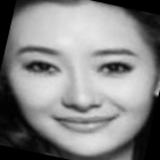

In [ ]:
face,status = align_face('/content/gdrive/My Drive/iss/project/data/aidai/1_0_aidai_0001.jpg')

cv2_imshow(face)

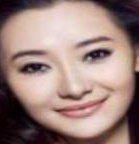

In [ ]:
org = cv2.imread('/content/gdrive/My Drive/iss/project/data/aidai/1_0_aidai_0001.jpg')
cv2_imshow(org)

In [ ]:
def samegroup(eye1,eye2):
  dx = min(eye1[0]+eye1[2], eye2[0]+eye1[2]) - max(eye1[0], eye2[0])
  dy = min(eye1[1]+eye1[3], eye2[1]+eye1[3]) - max(eye1[1], eye2[1])
  if (dx>=0) and (dy>=0) and (dx*dy>0.5):
      return True
  return False

def get_eyes(roi_gray):
  # Creating variable eyes
  haarcascade_lefteye_2splits1 = haarcascade_lefteye_2splits.detectMultiScale(roi_gray, 1.1, 3)
  haarcascade_righteye_2splits1 = haarcascade_righteye_2splits.detectMultiScale(roi_gray, 1.1, 3)
  eyeglasses1 = haarcascade_eye_tree_eyeglasses.detectMultiScale(roi_gray, 1.1, 3)

  eye_group = []
  group = 0
  for (ex , ey,  ew,  eh) in haarcascade_lefteye_2splits1:
    eye_group.append([ex , ey,  ew,  eh, group])
    group += 1
    #cv2.rectangle(lefteyexml,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
  for (ex , ey,  ew,  eh) in haarcascade_righteye_2splits1:
    grouped = False
    for g in eye_group:
      if samegroup([ex , ey,  ew,  eh],g):
        eye_group.append([ex , ey,  ew,  eh, g[4]])
        grouped = True
        break
    if grouped == False:
      eye_group.append([ex , ey,  ew,  eh, group])
      group +=1
  for (ex , ey,  ew,  eh) in eyeglasses1:
    grouped = False
    for g in eye_group:
      if samegroup([ex , ey,  ew,  eh],g):
        eye_group.append([ex , ey,  ew,  eh, g[4]])
        grouped = True
        break
    if grouped == False:
      eye_group.append([ex , ey,  ew,  eh, group])
      group +=1
    #cv2.rectangle(eyeglassesxml,(ex,ey),(ex+ew,ey+eh),(255,255,255),2)
  #print("total groups : "+str(group))
  eyes = []
  for i in range(group):
    ecount = 0
    ex = 0
    ey = 0
    ew = 0
    eh = 0
    for e in eye_group:
      if e[4] == i:
        ex += e[0]
        ey += e[1]
        ew += e[2]
        eh += e[3]
        ecount+=1
    if ecount > 1:
      ex = int(ex/ecount)
      ey = int(ey/ecount)
      ew = int(ew/ecount)
      eh = int(eh/ecount)
    #print("Group : "+str(i))
    #print("position : {},{},{},{}",ex,ey,ew,eh)
    if len(eyes) <2 :
      if len(eyes) == 1:
        tmp = eyes[0]
        if eyes[0][2]*eyes[0][3] < ew*eh:
          eyes[0] = [ex,ey,ew,eh]
          eyes.append(tmp)
        else:
          eyes.append([ex,ey,ew,eh])
      else:
        eyes.append([ex,ey,ew,eh])
      #print(len(eyes))
    else:
      if eyes[0][2]*eyes[0][3] < ew*eh:
        tmp = eyes[0]
        eyes[0] = [ex,ey,ew,eh]
        eyes[1] = tmp
      elif eyes[1][2]*eyes[1][3] < ew*eh:
        eyes[1] = [ex,ey,ew,eh]
  return eyes



def eye_detect(img_path):
    img = cv2.imread(img_path)
    status = False
    img_original = img    

    lefteyexml = img
    righteyexml = img
    eyexml = img
    eyeglassesxml = img

    lefteyexml2 = img
    righteyexml2 = img
    eyexml2 = img
    eyeglassesxml2 = img

    lefteyexml3 = img
    righteyexml3 = img
    eyexml3 = img
    eyeglassesxml3 = img

    # Converting the image into grayscale
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f_count = 0
    #try:
    # Creating variable faces
    faces= face_cascade.detectMultiScale (gray, 1.1, 4)
    # Defining and drawing the rectangle around the face
    for(x,y,w,h) in faces:
      f_count+=1
    # Creating two regions of interest
    roi_gray=gray
    roi_color=img
    
    eyes = get_eyes(roi_gray)    

    #for e in eyes:
    #  cv2.rectangle(eyeglassesxml,(e[0],e[1]),(e[0]+e[2],e[1]+e[3]),(0,0,255),2)

    if len(eyes) ==2:
      # Creating for loop in order to divide one eye from another
      eye_1 = eyes[0]
      eye_2 = eyes[1]
      
      if eye_1[0] < eye_2[0]:
          left_eye = eye_1
          right_eye = eye_2
      else:
          left_eye = eye_2
          right_eye = eye_1
      # Calculating coordinates of a central points of the rectangles
      left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
      left_eye_x = left_eye_center[0] 
      left_eye_y = left_eye_center[1]
        
      right_eye_center = (int(right_eye[0] + (right_eye[2]/2)), int(right_eye[1] + (right_eye[3]/2)))
      right_eye_x = right_eye_center[0]
      right_eye_y = right_eye_center[1]

      if left_eye_y > right_eye_y:
          A = (right_eye_x, left_eye_y)
          # Integer -1 indicates that the image will rotate in the clockwise direction
          direction = -1 
      else:
          A = (left_eye_x, right_eye_y)
        # Integer 1 indicates that image will rotate in the counter clockwise  
        # direction
          direction = 1 

      delta_x = right_eye_x - left_eye_x
      delta_y = right_eye_y - left_eye_y
      angle=np.arctan(delta_y/delta_x)
      angle = (angle * 180) / np.pi

      # Width and height of the image
      h, w = img.shape[:2]
      # Calculating a center point of the image
      # Integer division "//"" ensures that we receive whole numbers
      center = (w // 2, h // 2)
      # Defining a matrix M and calling
      # cv2.getRotationMatrix2D method
      M = cv2.getRotationMatrix2D(center, (angle), 1.0)
      # Applying the rotation to our image using the
      # cv2.warpAffine method
      rotated = cv2.warpAffine(img_original, M, (w, h))

      rotated = cv2.resize(rotated,(160,160),interpolation=cv2.INTER_CUBIC)
      rotated = cv2.cvtColor(rotated,cv2.COLOR_BGR2GRAY)
      rotated = cv2.cvtColor(rotated,cv2.COLOR_GRAY2RGB)
      status = True
      #return rotated,status
      cv2_imshow(rotated)

    cv2_imshow(lefteyexml)

    status = True
    return status
    #except:
    #    return status

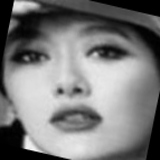

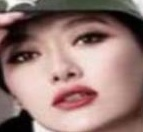

In [ ]:
status = eye_detect('/content/gdrive/My Drive/iss/project/data/aidai/1_0_aidai_0058.jpg')

1
2


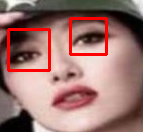

In [ ]:
status = eye_detect('/content/gdrive/My Drive/iss/project/data/aidai/1_0_aidai_0058.jpg')

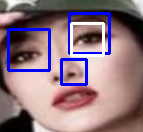

In [ ]:
status = eye_detect('/content/gdrive/My Drive/iss/project/data/aidai/1_0_aidai_0058.jpg')

In [ ]:
int(22.2)

22